<a href="https://colab.research.google.com/github/hanbitlee/summer_2021/blob/main/pmf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from numpy import *
import random
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/DSAIL_2021/ml-100k'

def load_rating_data(file_path= path):
    
    prefer = []
    for line in open(file_path, 'r'):
        (userid, movieid, rating, ts) = line.split('\t') 
        uid = int(userid)
        mid = int(movieid)
        rat = float(rating)
        prefer.append([uid, mid, rat])
    data = array(prefer)
    return data


def spilt_rating_dat(data, size=0.2):
    train_data = []
    test_data = []
    for line in data:
        rand = random.random()
        if rand < size:
            test_data.append(line)
        else:
            train_data.append(line)
    train_data = array(train_data)
    test_data = array(test_data)
    return train_data, test_data


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)

        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []

    # Fit the model with train_tuple and evaluate RMSE on both train and test data.

    def fit(self, train_vec, test_vec):
        # mean subtraction
        self.mean_inv = np.mean(train_vec[:, 2])  # average rating

        pairs_train = train_vec.shape[0]  # train data number of entries
        pairs_test = test_vec.shape[0]  # test data number of entries

        # 1-p-i, 2-m-c
        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  # 0th column, number of users 
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  # 1st column, number of movies 

        incremental = False 
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)  # numpy.random.randn movie M * D  normal distribution matrix
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # numpy.random.randn users N x D normal distribution matrix

            self.w_Item_inc = np.zeros((num_item, self.num_feat))  # create M X D zero matrix
            self.w_User_inc = np.zeros((num_user, self.num_feat))  # create N X D zero matrix

        while self.epoch < self.maxepoch:  
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order) 

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # index subscript to be used in this iteration

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_vec[:, 2] + self.mean_inv
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    # Print info
                    if batch == self.num_batches - 1:
                        print('Training RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self, invID):
        return np.dot(self.w_Item, self.w_User[int(invID), :]) + self.mean_inv  # numpy.dot product

    # Set parameters by providing a parameter dictionary
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  # numpy.argsort sorting

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)

943 1682 10
Training RMSE: 1.123849, Test RMSE 1.125189
Training RMSE: 1.121419, Test RMSE 1.124786
Training RMSE: 1.117251, Test RMSE 1.122941
Training RMSE: 1.106916, Test RMSE 1.116138
Training RMSE: 1.080930, Test RMSE 1.096545
Training RMSE: 1.035885, Test RMSE 1.062341
Training RMSE: 0.987900, Test RMSE 1.028010
Training RMSE: 0.948534, Test RMSE 1.000821
Training RMSE: 0.919716, Test RMSE 0.981891
Training RMSE: 0.897738, Test RMSE 0.968458


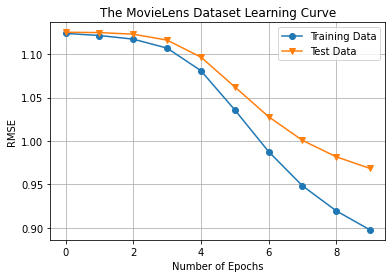

precision_acc,recall_acc:(0.05711252653927844, 0.029743480641455246)


In [ ]:
import numpy as np
if __name__ == "__main__":
    path = '/content/drive/My Drive/DSAIL_2021/ml-100k/u.data'
    pmf = PMF()
    pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 10, "num_batches": 100,
                    "batch_size": 1000})
    ratings = load_rating_data(path)
    print(len(np.unique(ratings[:, 0])), len(np.unique(ratings[:, 1])), pmf.num_feat)
    train, test = train_test_split(ratings, test_size=0.2)  # spilt_rating_dat(ratings)
    pmf.fit(train, test)

    # Check performance by plotting train and test errors
    plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
    plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
    plt.title('The MovieLens Dataset Learning Curve')
    plt.xlabel('Number of Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()
    print("precision_acc,recall_acc:" + str(pmf.topK(test)))
